# CpG methylation

This notebook gets genome-wide methylation levels at CpG sites, from the gnomAD non-coding constraint paper.

## Preliminaries

In [ ]:
%%bash

# Get the "context_prepared.ht" Hail table from Google Cloud storage
# Takes ~1.5 hours
dx download scripts/get_ht.sh
bash get_ht.sh

# Upload the Hail table to the hadoop file system
# Takes ~3 hours
hdfs dfs -put context_prepared.ht/ .

In [1]:
# Import the relevant modules
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
import hail as hl

# Initialise Hail on the Spark cluster
builder = (
    SparkSession
    .builder
    .enableHiveSupport()
)
spark = builder.getOrCreate()
hl.init(sc=spark.sparkContext)

pip-installed Hail requires additional configuration options in Spark referring
  to the path to the Hail Python module directory HAIL_DIR,
  e.g. /path/to/python/site-packages/hail:
    spark.jars=HAIL_DIR/hail-all-spark.jar
    spark.driver.extraClassPath=HAIL_DIR/hail-all-spark.jar
    spark.executor.extraClassPath=./hail-all-spark.jarRunning on Apache Spark version 2.4.4
SparkUI available at http://ip-10-60-109-92.eu-west-2.compute.internal:8081
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.78-b17627756568
LOGGING: writing to /opt/notebooks/hail-20230210-2205-0.2.78-b17627756568.log


## Data munging

In [22]:
ht = hl.read_table("context_prepared.ht")

In [3]:
ht = ht.filter(ht.variant_type == "CpG")
ht = ht.select("methyl_level")

In [4]:
ht.show(5)

,,
locus,alleles,methyl_level
locus<GRCh38>,array<str>,int32
chr1:10469,"[""C"",""T""]",1
chr1:10470,"[""G"",""A""]",1
chr1:10471,"[""C"",""T""]",2
chr1:10472,"[""G"",""A""]",2
chr1:10484,"[""C"",""T""]",2


In [5]:
# Convert to pandas dataframe
# Takes ~ 1 hour
df = ht.to_pandas()

In [6]:
df.head()

,locus.contig,locus.position,alleles,methyl_level
0,chr1,10469,"[C, T]",1
1,chr1,10470,"[G, A]",1
2,chr1,10471,"[C, T]",2
3,chr1,10472,"[G, A]",2
4,chr1,10484,"[C, T]",2


In [7]:
df.shape

(58305759, 4)

In [8]:
df.to_csv("./grch38_cpg_methylation.tsv", sep="\t")

In [9]:
%%bash
dx upload --destination /data/ grch38_cpg_methylation.tsv

ID                          file-GPYGvkQJ7yj0XK8f30GPxZKy
Class                       file
Project                     project-GKK5xq0J7yj8yZZ863Jgg51x
Folder                      /data
Name                        grch38_cpg_methylation.tsv
State                       closing
Visibility                  visible
Types                       -
Properties                  -
Tags                        -
Outgoing links              -
Created                     Fri Feb 10 23:08:22 2023
Created by                  alexander.blakes
 via the job                job-GPY1GbjJ7yj0q9JJXYv0xZg4
Last modified               Fri Feb 10 23:08:29 2023
Media type                  
archivalState               "live"
cloudAccount                "cloudaccount-dnanexus"


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3ed9cabd30>]],
      dtype=object)

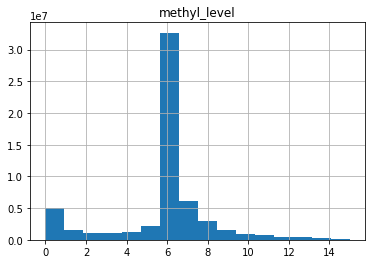

In [17]:
df.hist("methyl_level", bins=16)